# Getting Started 

#### Objective: Find a place, search for imagery, and rasterize it.

This tutorial demonstrates a few of the basic APIs in the Descartes Labs Platform. We’ll start by figuring out where we want to look. This will utilize the Places functionality. From there, we’ll briefly cover how to search for products using the Metadata API and what a GeospatialContext is. Next, we will demonstrate how to search for products and filter imagery using the Scenes API. Finally, we’ll rasterize the available imagery into a numpy array and display it using their built in methods.


In [1]:
import descarteslabs as dl
import matplotlib.pyplot as plt

So you now have access to a giant archive of imagery. First question is – where do you want to look? You might answer this question in many ways, but one of the ways we can help is by providing mechanisms to find shapes of known places. Our Places API has a find method that does fuzzy-matching searches of places. As an example, let’s try to find Taos, New Mexico (a favorite place for Cartesians to go hiking, biking, camping, and skiing). 

In [2]:
# Find potential matches
matches = dl.places.find('new-mexico_taos')
matches

[
  {
    u'bbox': [-106.058364, 36.013014, -105.200117, 36.995841],
    u'id': 102081181,
    u'name': u'Taos',
    u'path': u'continent:north-america_country:united-st...n:new-mexico_district:northwest_county:taos',
    u'placetype': u'county',
    u'slug': u'north-america_united-states_new-mexico_northwest_taos'
  }
]

In [3]:
# The first one looks good to me, so lets make that our area of interest.
aoi = matches[0]

In [4]:
# This area of interest just gives us some basic properties such as bounding boxes.
# To access a GeoJSON Geometry object of that place, we call the `Places.shape` method, in this case
# accessing a low-resolution version of this particular shape.
shape = dl.places.shape(aoi['slug'], geom='low')

If our Places API does not have the boundary you need, or you are working with a unique geometry, you can use your own custom GeoJSON shapes with the rest of our APIs seamlessly. 

## Searching for available imagery 
The Descartes Labs platform pulls together data from over 75 different sources. We call each of these distinct offerings products, and they all have their own unique IDs. Even derived or external data you save into the platform has a product ID. The first parameter when searching for data is a list of product IDs to specify what kind of imagery you want returned. 
To view products you have access to, you can use the [catalog interface](https://catalog.descarteslabs.com/) which allows you to search our products and displays all their metadata information including details about spectral bands, classes, lifespan, and more. The catalog is an interface for our Metadata API. You can get back all the same information programmatically using the Metadata API. 

In [5]:
# Return all the products you have access to
products = dl.metadata.products() 
print("I currently have access to {} products. Some of these may not be publically available.".format(len(products)))

I currently have access to 224 products. Some of these may not be publically available.


In [6]:
# Get back all band names based on a product ID 
bands = dl.metadata.bands('landsat:LC08:PRE:TOAR')
[band['name'] for band in bands]

[u'coastal-aerosol',
 u'blue',
 u'green',
 u'red',
 u'nir',
 u'swir1',
 u'swir2',
 u'cirrus',
 u'tirs1',
 u'alpha',
 u'bright-mask',
 u'cloud-mask',
 u'qa_cirrus',
 u'qa_cloud',
 u'qa_snow',
 u'qa_water']

## Lets find some Landsat 8 imagery over our AOI using the Scenes API
There are two ways to search for and obtain data: the Scenes API, or a combination of the Metadata API and Raster APIs. The Scenes API handles the details of scaling, clipping, resolution, coordinate systems, and no data values through a paradigm we call a GeospatialContext, while the latter requires more knowledge of the imagery you are requesting. We will focus on the Scenes API for the remainder of this tutorial. 

In [59]:
# Create a SceneCollection matching our search criteria and view its summary
scenes, ctx = dl.scenes.search(shape['geometry'],
                    products="landsat:LC08:01:RT:TOAR",
                    start_datetime="2017-11-01",
                    end_datetime="2018-07-01",
#                     cloud_fraction=0.7,
                    limit=500
                   )
scenes

SceneCollection of 60 scenes
  * Dates: Nov 08, 2017 to Jun 27, 2018
  * Products: landsat:LC08:01:RT:TOAR: 60

## Inspect the GeospatialContext of the SceneCollection 
When a SceneCollection is created, an associated GeospatialContext is instantiated which intelligently sets defaults for rasterizing the imagery. This includes: 
* Cutline/bounds
* Resolution
* CRS
* Target Align Pixels

A GeospatialContext is immutable, but you can overwrite the default values by creating a new context as demonstrated below. 

In [45]:
# View the context of our SceneCollection
ctx

AOI(geometry=<shapely...1cc58fd0>,
    resolution=15,
    crs=u'EPSG:32613',
    align_pixels=True,
    bounds=(-106.058364, 36.013014, -105.200117, 36.995841),
    shape=None)

In [46]:
# Create a copy of the original context, and set the resolution to 30m.
highres_context = ctx.assign(resolution=120)

The Scenes API uses Shapely under the hood. This means you have accesss to all the Shapely functionality such as plotting the geometry.

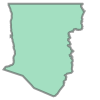

In [10]:
# Plot the shape of Taos inline using the geometry method. 
ctx.geometry

## Display a single image

The original Scene Collection has 41 Scenes, though no single Scene has data covering our entire AOI. Before we mosaic the data, let's take a look at a single scene, accessing its data in the form of an ndarray.

In [99]:
# Pick a Scene that has more than a sliver of data within our AOI.
scene = scenes[16]

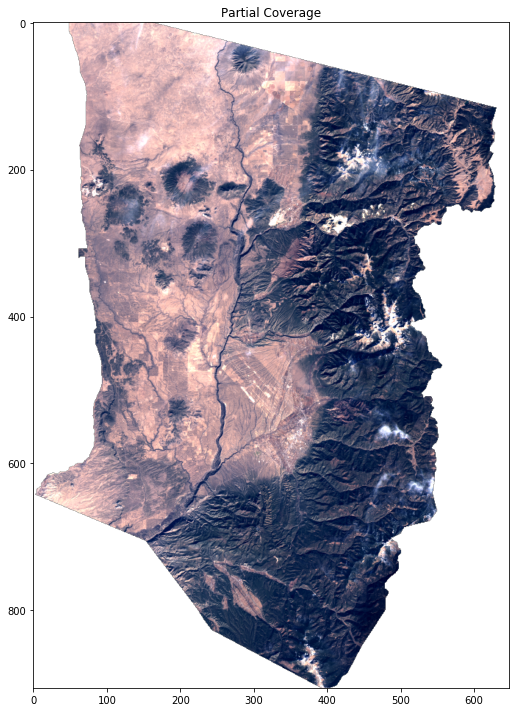

In [100]:
# A Scene or SceneCollection only contains the Metadata for the imagery
# We have to use another method to get the data back, in this case, the ndarray method
# Note that we are passing in the high resolution GeospatialContext
arr = scene.ndarray("red green blue", highres_context)
dl.scenes.display(arr, title="Partial Coverage")

## Create a mosaic of the SceneCollection

Now that we understand what a single Scene is, let's take a look at the SceneCollection. We know a single image provides insufficient data for our AOI. The image above is missing data in the upper right hand corner of the shape. The built in method mosaic will give us complete coverage. It returns a single masked array containing both the spectral data requested and the mask for no data values. 

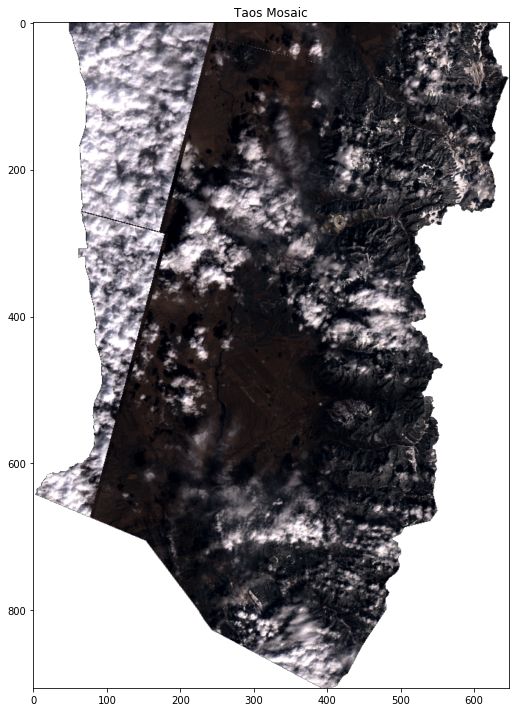

In [51]:
# Request a mosaic of data containing the red green and blue bands
mosaic = scenes.mosaic("red green blue", highres_context)
dl.scenes.display(mosaic, title="Taos Mosaic")

## Create a cloud free composite

The mosaic function simply takes the last valid data value for any given pixel location, sometimes resulting in cloudy or less than expected results as seen above. One way to avoid this, is using the built in stack method and NumPy median method. A call to stack returns each Image's data and no data alpha mask seperately within a single masked array. We can then use the NumPy median method to create a composite free of clouds and other irregularities. 

In [61]:
# Request a stack of data containing the red green and blue bands.
stack = scenes.stack("red green blue", highres_context)
print("The stack method returns a {} containing the data for the same {} Scenes returned by the search method above.".format(type(stack),len(stack)))

The stack method returns a <class 'numpy.ma.core.MaskedArray'> containing the data for the same 60 Scenes returned by the search method above.


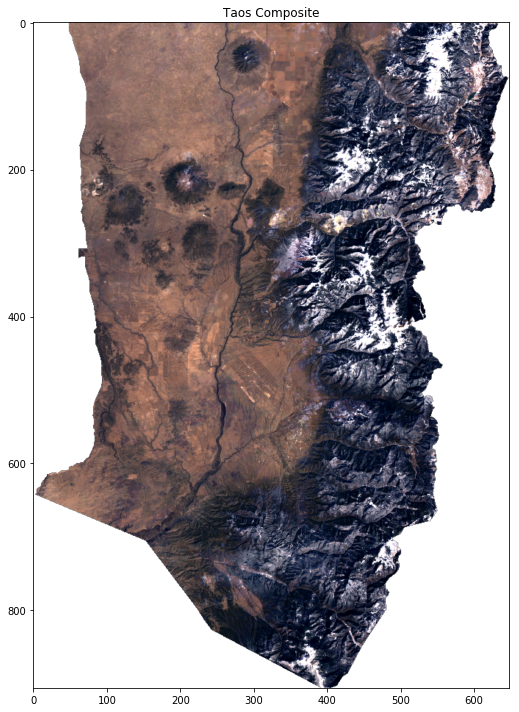

In [62]:
# We import the NumPy library so we can call the median method on our masked array to produce the final dataset
import numpy as np
composite = np.ma.median(stack, axis=0)
dl.scenes.display(composite, title="Taos Composite")

Of course, you can work with any number of bands available for analysis and visualization. To complete the tutorial, let's use the same process to display a false color image. Areas that appear red indicate healthy vegetation.

In [65]:
false_color_stack = scenes.stack("nir swir1 swir2", highres_context)

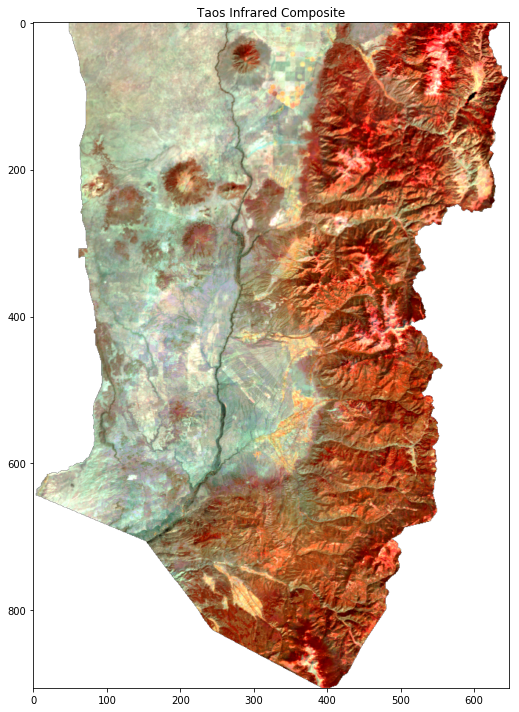

In [66]:
composite = np.ma.median(false_color_stack, axis=0)
dl.scenes.display(composite, title="Taos Infrared Composite")